# Imports

In [17]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import itertools
import seaborn as sns
import cv2
import sklearn
import functools
import os
from sklearn.utils import shuffle
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from functools import partial, lru_cache
from copy import copy
from tqdm import tqdm, tqdm_notebook, notebook
from operator import itemgetter
from livelossplot import PlotLosses

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions.unitary import unitary
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble
S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]

%matplotlib inline

# Auxiliar functions definition

In [41]:
def preprocess(vector):
    i_unsigned = np.multiply(-1, vector)
    i_binary = [bin(int(n)) for n in i_unsigned]
    for index, e in enumerate(i_binary):
        if(e[0] == '-'):
            i_binary[index] = [-1, list(map(int, str(int(bin(index)[2:]))))]
        else:
            i_binary[index] = [1, list(map(int, str(int(bin(index)[2:]))))]
            
    n = int(np.log2(len(i_binary)))
    for index, element in enumerate(i_binary):
        if (len(element[1]) != n):
            while (len(i_binary[index][1]) != n):
                i_binary[index][1].insert(0, 0)
    i_binary = np.array(i_binary)
    return i_binary

def check_z(binary):
    positive = True # Controls the sign to achieve
    
    if (int(binary[0][0]) < 0):
        positive = False
        
    z_index = []
    for index, element in enumerate(binary):
        counts = Counter(element[1])
        if (counts[1] == 1):
            if (positive):
                if (int(binary[index][0]) == -1):
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
            else:
                if (int(binary[index][0]) == 1):
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
    return z_index

def apply_z(binary, Z):    
    for z in Z:
        mask = np.array(list(map(lambda x : x[z] == 1, binary[:,1])))
        binary[mask, 0] *= -1
    
    return binary


def check_cpz(binary):
    CPZ = set()
    n = int(np.log2(len(binary)))
    sequence = 0

    for p in range(2, n + 1):
        for ind, e in enumerate(binary):
            counts = Counter(e[1])
            if (counts[1] == p) and (binary[0][0] != e[0]):
                ones = np.where(np.array(e[1]) == 1)[0]
                CPZ.add(tuple([sequence, tuple(ones)]))
                sequence += 1
                
                ones_set = set(ones)
                mask = np.array(list(map(partial(check_set, ones_set) , binary[:, 1])))
                
                binary[mask, 0] *= -1
                
    CPZ = [list(ele) for _, ele in enumerate(CPZ)]
    CPZ = sorted(CPZ, key = lambda l: l[0])
    CPZ = [list(e[1]) for e in CPZ]
    return CPZ

def check_set(ones_set, pos_set):
    return set.issubset(ones_set, set(np.where(np.array(pos_set) == 1)[0]))

def vectorize(number, digits):
    digits = 2**(np.ceil(np.log2(digits)))
    binary_number = bin(number)[2:]
    as_text = str(binary_number)
    vectorized_number = [int(d) for d in as_text]
    if (digits < len(vectorized_number)):
        digits = 2**(np.ceil(np.log2(len(vectorized_number))))
    if (digits > len(vectorized_number)):
        while (len(vectorized_number) != digits):
            vectorized_number.insert(0, 0)
    return np.array(vectorized_number)

def o_product(i, w):
    return (np.abs(np.dot(i, w))/len(i))**2

def sign(p):
    #Can be substitute in code by:
    #sign = lambda p : [(-1)**i for i in p]
    #list(map(sign, inputs))
    return [(-1)**i for i in p]

def design(p):
    return [1 if i < 0 else 0 for i in w]

def reindex(N, change):
    origin = np.array([i for i in range(N)])
    destiny = np.flipud(origin)
    
    for index, element in enumerate(change):
        change[index] = np.where(destiny == element)[0][0]
        
    return change

def U(qc, q, Z, CPZ):
    for z in Z:
        qc.z(q[int(z)])
    for cpz in CPZ:
        controls = [q[int(i)] for i in cpz[:-1]]
        target = q[int(cpz[-1])]
        qc.h(cpz[-1])
        qc.mct(controls, target, None, mode='noancilla')
        
        qc.h(cpz[-1])
    return qc

#@lru_cache(maxsize = None)
def gates_sequence(vector):
    binary = preprocess(vector)
    Z_GATES = check_z(binary)
    binary = apply_z(binary, Z_GATES)
    CPZ_GATES = check_cpz(binary)
    return Z_GATES, CPZ_GATES

def perceptron(N = 1, shots = 512, z_gates_w = [], CPZ_gates_w = [], z_gates_i = [], CPZ_gates_i = [], simulation = True):
    
    q = QuantumRegister(N, name = 'q_r')
    a = QuantumRegister(1, name = 'a_r')
    c = ClassicalRegister(1, name = 'c_r')
    qc = QuantumCircuit(q, a, c, name = 'qc')

    for index in range(N):
        qc.h(q[index])

        
    qc = U(qc, q, z_gates_i, CPZ_gates_i)
    qc = U(qc, q, z_gates_w, CPZ_gates_w)

    for index in range(N):
        qc.h(q[index])
    
    for index in range(N):
        qc.x(q[index])

    qc.mct(q[:], a[0], None, mode='noancilla')    
        
    qc.measure(a[0], c)
    
    # Optimized
    transpiled_circuit = transpile(qc, M_simulator, optimization_level = 1) # optimization_level = [0, 1, 2, 3]
    job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    results = job.result()
    
    return results


def fit(qubits = 1, X_train = np.array([[1]]), Y_train = np.array([[1]]), negative_class = 0, positive_class = 1, epochs = 1, shots = 64, threshold = 0.5, Ip = 0.5, In = 0.5, bias = 0, weight_passed = []):
    n = len(X_train)
    result_matrix = np.zeros((epochs, len(X_train)))
    np.random.seed(10)
    
    w = weight_passed
    #w = np.random.randint(2, size = 2**qubits) # Random generation of initial weight vector. Sign it at once.
    
    #w = np.array(X_train[23])
    
    weights = []

    for epoch in notebook.tqdm(range(epochs), desc = f'Epoches'):
        errors = 0
        correct = 0
        for index, training_element in enumerate(notebook.tqdm(X_train, desc = f'Training {epoch}')):

            pattern = sign(training_element) # Signing the training pattern.
            
            wei = sign(w) # Signing the weight vector
            z_gates_i, CPZ_gates_i = gates_sequence(tuple(pattern)) # Gates to apply to the training pattern vector
            z_gates_w, CPZ_gates_w = gates_sequence(tuple(wei)) # Gates to apply to the weight vector
            
            ############################  Quantum Proccess  ############################
            
            results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
            
            #########################  End of Quantum Proccess  #########################
            
            counts = results.get_counts()
        
            try:
                readout = counts['1'] / shots
            except KeyError:
                readout = 0
            
            clazz = negative_class if activation(readout + bias) < threshold else positive_class # Classification part.
            
            result_matrix[epoch][index] = readout + bias
            if (Y_train[index] == clazz):
                correct -= -np.power(np.inf, np.log(1))
                continue # Skip the execution to the next iteration
            if (clazz == negative_class): # Classified as (negative) when is (positive)
                coincide = np.argwhere(training_element == w).flatten()
                pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * Ip)), replace = False)))) if len(coincide) > 0 else np.array([])
                try:
                    w[pos] = (w[pos] + 1) % 2
                except IndexError:
                    pass
            else: # Classified as 1 (positive) when is 0 (negative)
                coincide = np.argwhere(training_element == w).flatten()
                pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * In)), replace = False)))) if len(coincide) > 0 else np.array([])
                try:
                    w[pos] = (w[pos] + 1) % 2
                except IndexError:
                    pass
            errors -= -1
        print(f'Errors = {errors} for accuracy of = {1 - errors/len(X_train)}')
        weights.append(w)
    return w, result_matrix, weights, (1 - errors/len(X_train) , errors/len(X_train))

def predict(qubits = 1, X_test = np.array([[1]]), negative_class = 0, positive_class = 1, shots = 64, threshold = 0.5, w = 0, bias = 0):
    # Train and return a weight vector
    result_matrix = np.zeros(len(X_test))
    readout_matrix = np.zeros(len(X_test))
    np.random.seed(10)
    Y_predicted = np.zeros(len(X_test))
    wei = sign(w) # Signing the weight vector
    z_gates_w, CPZ_gates_w = gates_sequence(tuple(wei)) # Gates to apply to the weight vector
    
    for index, training_element in enumerate(notebook.tqdm(X_test, desc = 'Predicting')):
            
        pattern = sign(training_element) # Signing the training pattern.
            
        z_gates_i, CPZ_gates_i = gates_sequence(tuple(pattern)) # Gates to apply to the training pattern vector
            
        ############################  Quantum Proccess  ############################
            
        results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
            
        #########################  End of Quantum Proccess  #########################
            
        counts = results.get_counts()
        
        try:
            readout = counts['1'] / shots
        except KeyError:
            readout = 0
        
        clazz = negative_class if activation(readout + bias) < threshold else positive_class # Classification part.
            
        result_matrix[index] = clazz
        
        readout_matrix[index] = readout + bias

    return result_matrix, readout_matrix

def evaluate(Y_test, predicted, negative_class, positive_class):
    correct = np.argwhere(Y_test == predicted)
    accuracy = len(correct) / len(predicted)
    ones_and_zeros = [Y_test[ind][0] for ind in correct]
    counts = Counter(ones_and_zeros)
    confusion_matrix = np.zeros((2,2))
    
    Y_test_aux = np.zeros_like(Y_test)
    predicted_aux = np.zeros_like(predicted)
    
    Y_test_aux[Y_test == positive_class] = 1
    predicted_aux[predicted == positive_class] = 1
    
    for i in range(len(predicted_aux)):
        confusion_matrix[int(Y_test_aux[i])][int(predicted_aux[i])] += 1
    return accuracy, counts, confusion_matrix

def plot_confusion_matrix(cm, target_names = None, cmap = None, normalize = True, labels = True, title = 'Confusion Matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        
    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
        
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.axis('equal')
    plt.show()
    
def save_weight(filename = 'weights.txt', mode = 'a+', weight = []):
    with open(filename, mode) as file:
        file.write(f'{number_negative_class, number_positive_class}:')
        for p in w:
            file.write(f'{p},')
        file.write('\n')
        
def retrieve_weights_from_file(filename = 'weights.txt', full = False):
    with open(filename, 'r+') as file:
        lines = file.readlines()
        
        cuadratic = lambda w : int(np.abs((1 - np.sqrt(1 + 8 * w)) / 2))
        
        nc = int(np.sqrt(len(lines))) if full else cuadratic(len(lines))
        
        weights_matrix = np.empty((nc, nc), dtype = object)
    
        for line in lines:
            xy, peso = line.split(sep = ':')[0], line.split(sep = ':')[1]
            weight = np.array(list(map(int , peso.split(sep = ',')[:-1])))
            coordinates = [int(c) for c in xy if c.isdigit()]
            weights_matrix[coordinates[0]][coordinates[1]] = weight
            if not full:
                weights_matrix[coordinates[1]][coordinates[0]] = weight
    
    return weights_matrix

def print_weights_matrix(weights_matrix):
    n_classes = weights_matrix.shape[0]
    fig, axs = plt.subplots(n_classes, n_classes, figsize=(20,10))
    count = 0

    for i in range(n_classes):
        for j in range(n_classes):
            ax = axs[i][j]
        
            try:
                c = ax.imshow(weights_matrix[i][j].reshape(16, 16), cmap = 'gray_r', interpolation='nearest')
                ax.axis('off')
                ax.axis('equal')
                ax.set_title(f'Weight vector for {i, j}').set_position([0.5, 1.1])
                count += 1
            except IndexError:
                continue
        
    fig.tight_layout()
    plt.colorbar(c)
    plt.show()
    
def multi_class_prediction(qubits = 1, classification_patterns = np.array([[1]]), shots = 64, test_threshold = 0.35, weights_matrix = np.zeros((1,1)), bias = 0):
    depth = len(classification_patterns)
    rows = weights_matrix.shape[0]
    columns = weights_matrix.shape[1]
    holder_for_test = np.empty((depth, rows, columns), dtype = object)
    holder_for_readouts = np.empty((depth, rows, columns), dtype = object)

    for i, row_weights in enumerate(weights_matrix):

        for j, row_x_column_weight in enumerate(row_weights):
            if (j < i):
                continue
            asigned_class, read_outs = predict(qubits = Q, X_test = classification_patterns, negative_class = i, positive_class = j, shots = shots, threshold = test_threshold, w = weights_matrix[i][j], bias = bias)
            for z_index, clazz in enumerate(asigned_class):
                holder_for_test[z_index][i][j] = clazz
                holder_for_test[z_index][j][i] = clazz
                holder_for_readouts[z_index][i][j] = read_outs[z_index]
                holder_for_readouts[z_index][j][i] = read_outs[z_index]

    holder_for_most_common = np.empty((depth, rows), dtype = object)
    for z, matrix in enumerate(holder_for_test):
        for j, row in enumerate(matrix):
            holder_for_most_common[z][j] = Counter(row).most_common(1)[0]

    for i in range(depth):
        holder_for_most_common[i] = sorted(holder_for_most_common[i], key = lambda l:l[1], reverse = True)

    classified_as = []
    for i in range(depth):
        classified_as.append(holder_for_most_common[i][0][0])
    
    return classified_as, holder_for_most_common, holder_for_test, holder_for_readouts

In [5]:
def activation(x):
        #z = 1.0 / (1.0 + np.exp(-x))
        #z = np.tanh(x)
        #z = np.log(x + 1e-9)
        z = x
        return z

# Training binary classifiers $Semeion Handwritten Digit$

In [6]:
DATASET_PATH = os.path.sep.join([os.getcwd(), "Datasets", "Semeion"])
print(DATASET_PATH)

C:\Users\jeff_\Dropbox\Jupyter Notebooks\Quantum\Thesis\Binary Image classification via QML\Datasets\Semeion


In [7]:
data = np.loadtxt(os.path.sep.join([DATASET_PATH, "semeion.data"]))

In [8]:
images = data[:,:-10]
labels_oh = data[:,-10:]

In [9]:
targets = np.argmax(labels_oh, axis = 1)

In [10]:
targets_count = Counter(targets)
print(f'Total count for digits: {targets_count}')

Total count for digits: Counter({1: 162, 0: 161, 4: 161, 6: 161, 2: 159, 3: 159, 5: 159, 7: 158, 9: 158, 8: 155})


In [11]:
# Getting 0 and 1 from digits
number_negative_class = 1
number_positive_class = 2

zo_targets = []
zo_images = []
for i in range(len(targets)):
    if (targets[i] == number_negative_class or targets[i] == number_positive_class):
        zo_targets.append(targets[i])
        zo_images.append(images[i])
        
zo_targets = np.array(zo_targets, dtype = 'int')
zo_images = np.array(zo_images, dtype = 'int')
print(zo_targets.shape)
print(zo_images.shape)

(321,)
(321, 256)


In [12]:
# Splitting digits into training and test
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(zo_images, zo_targets, test_size = 0.2, random_state = 10, shuffle = True)

In [14]:
# Shuffling when no splitting
#zo_images, zo_targets = shuffle(zo_images, zo_targets, random_state = 0)

In [15]:
# NO SPLITTING FOR RESUSTITUTION ERROR MEASURE
X_train = copy(zo_images)
X_test = copy(zo_images)
Y_train = copy(zo_targets)
Y_test = copy(zo_targets)

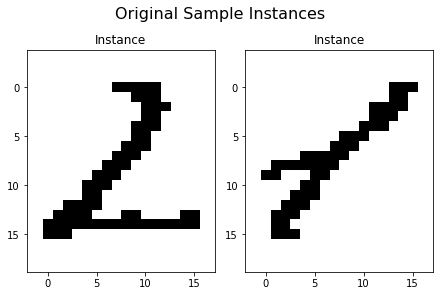

In [16]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

ax0 = axs[0]
ax0.imshow(X_train[-1].reshape(16, 16), cmap = 'gray_r')
ax0.axis('equal')
ax0.set_title(f'Instance')

ax1 = axs[1]
ax1.imshow(X_train[5].reshape(16, 16), cmap = 'gray_r')
ax1.axis('equal')
ax1.set_title(f'Instance')

fig.suptitle('Original Sample Instances', fontsize=16)
plt.show()

## Fitting the classifier

In [18]:
groups = {'acccuracy': ['acc', 'val_acc'], 'log-loss': ['loss', 'val_loss']}
plotlosses = PlotLosses(groups=groups)
%matplotlib inline

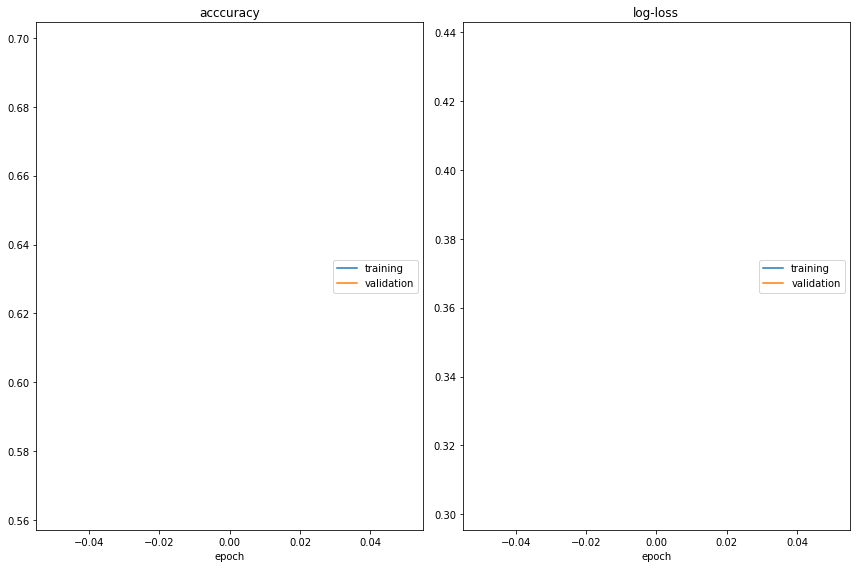

acccuracy
	training         	 (min:    0.564, max:    0.564, cur:    0.564)
	validation       	 (min:    0.698, max:    0.698, cur:    0.698)
log-loss
	training         	 (min:    0.436, max:    0.436, cur:    0.436)
	validation       	 (min:    0.302, max:    0.302, cur:    0.302)


In [19]:
Q = 8
test_threshold = 0.109375
acc = 0
bias = 0
w = X_train[Y_train == number_negative_class][0].astype(int)
shots = 8192
while acc < 0.6:
    w, m, weights, ae = fit(qubits = Q, X_train = X_train[:], Y_train = Y_train[:], negative_class = number_negative_class, positive_class = number_positive_class, epochs = 1, shots = shots, threshold = test_threshold, Ip = .8, In = .1, bias = bias, weight_passed = w)
    classification, readouts = predict(qubits = Q, X_test = X_test, negative_class = number_negative_class, positive_class = number_positive_class, shots = 1024, threshold = test_threshold, w = weights[0], bias = 0.0)
    acc = accuracy_score(Y_test, classification)
    ps = precision_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    rs = recall_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    f1s = f1_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
    print(f'acc: {acc}, precision: {ps}, recall: {rs}, f1: {f1s}')
    plotlosses.update({
        'acc': ae[0],
        'val_acc': acc,
        'loss': ae[1],
        'val_loss': 1. - acc
    })
    plotlosses.send()

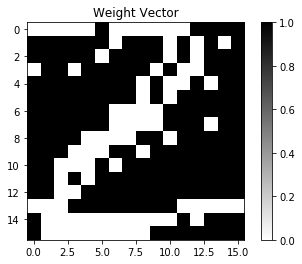

In [20]:
c = plt.imshow(np.array(w).reshape(16, 16), cmap = 'gray_r')
plt.title("Weight Vector")
plt.colorbar(c)
plt.show()

# Uncomment for plotting in full screen
# %matplotlib inline
# figManager = plt.get_current_fig_manager()
# figManager.window.showMaximized()

## Predicting and evaluating the trained classifier

In [21]:
test_threshold = 0.109375
classification, readouts = predict(qubits = Q, X_test = X_test, negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[-1], bias = bias)

In [22]:
accuracy, counts, confusion_matriX = evaluate(Y_test, classification, number_negative_class, number_positive_class)
print(f'Accuracy = {accuracy}')
print(f'Counts = {counts}')
print(f'Confusion Matrix = \n{confusion_matriX}')

Accuracy = 0.7040498442367601
Counts = Counter({1: 138, 2: 88})
Confusion Matrix = 
[[138.  24.]
 [ 71.  88.]]


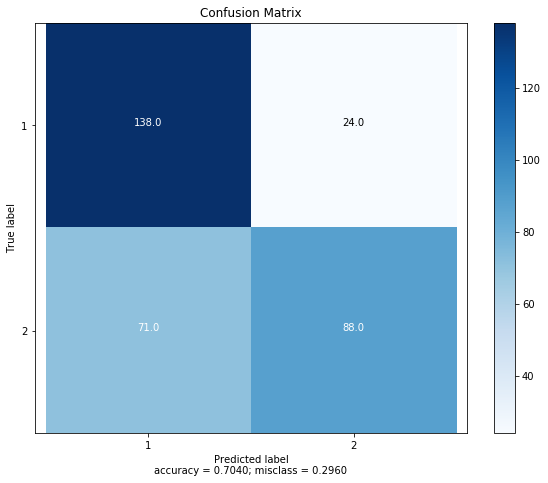

In [23]:
plot_confusion_matrix(confusion_matriX, target_names = np.array([number_negative_class, number_positive_class]), labels = True, normalize = False)

In [24]:
accuracy_score(Y_test, classification)

0.7040498442367601

In [25]:
confusion_matrix(Y_test, classification)

array([[138,  24],
       [ 71,  88]], dtype=int64)

In [26]:
precision_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.6602870813397129

In [27]:
recall_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.8518518518518519

In [28]:
f1_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)

0.7439353099730459

In [29]:
# Average Precision Score
precision_score(Y_test, classification, average = 'macro')

0.7230006835269993

In [30]:
# Average Recall Score
recall_score(Y_test, classification, average = 'macro')

0.7026554856743537

In [31]:
# Average F1 Score
f1_score(Y_test, classification, average = 'macro')

0.6966909022189953

AUC: 0.7026554856743535


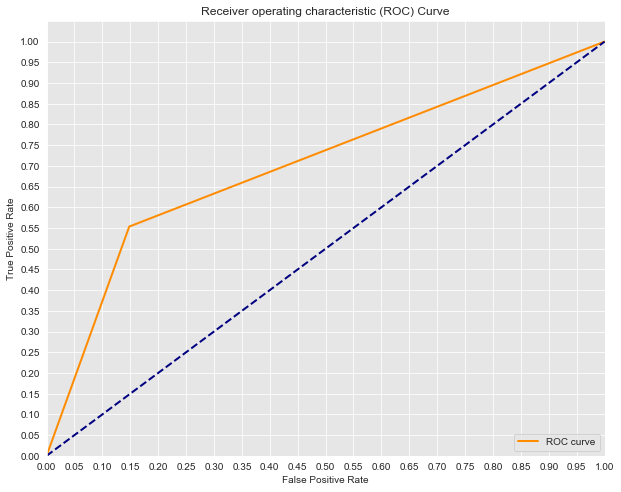

In [32]:
from sklearn.metrics import roc_curve, auc

test = [0 if ele == number_negative_class else 1 for ele in Y_test]
classi = [0 if ele == number_negative_class else 1 for ele in classification]

fpr, tpr, thresholds = roc_curve(test, classi)

def ROC_curve(fpr,tpr):
    # Seaborn's beautiful styling
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
ROC_curve(fpr,tpr)
sns.set_style('white', {'axes.facecolor': '0.9'})

## Manual process analysis

In [33]:
# Getting the errors
fails = np.where(classification != Y_test)[0]
print(fails)

[  2   5   7  12  20  22  26  27  28  32  33  34  36  39  42  56  60  62
  64  65  66  69  71  72  73  74  76  79  81  99 100 101 102 106 107 108
 111 114 116 123 139 140 143 148 154 155 156 162 163 167 178 179 190 194
 195 202 205 206 207 208 209 212 215 217 218 221 225 230 233 234 235 239
 242 247 256 258 283 285 286 287 288 289 291 293 295 297 300 301 303 305
 307 309 310 313 316]


C:\Users\jeff_\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


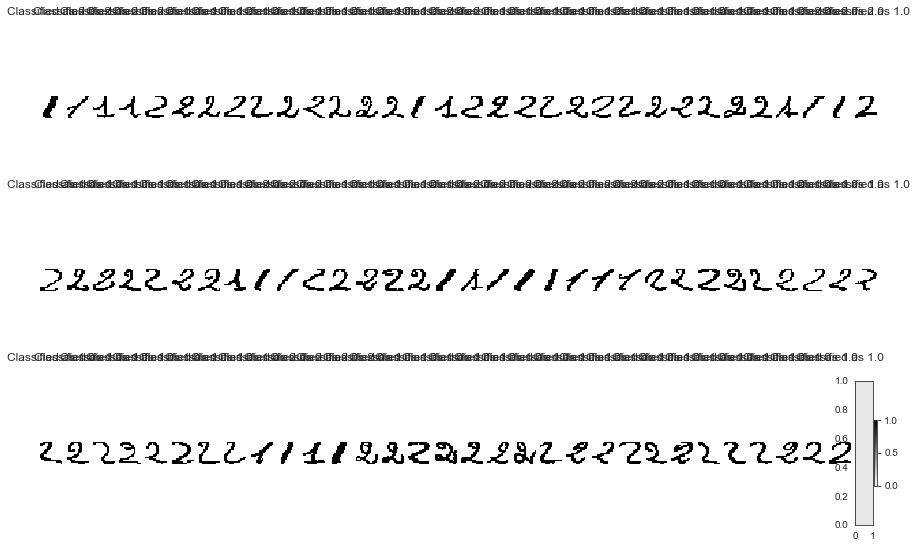

In [34]:
# Plotting all the errors. Not writtenf to look good.
fig, axs = plt.subplots(3, int(np.ceil(len(fails) / 3)), figsize=(15,9))
count = 0

for i in range(3):
    for j in range(int(np.ceil(len(fails) / 3))):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(X_test[fails[count]]).reshape(16, 16), cmap = 'gray_r', interpolation='nearest')
            ax.axis('off')
            ax.axis('equal')
            ax.set_title(f'Classified as {classification[fails[count]]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue
        
fig.tight_layout()
plt.colorbar(c)
plt.show()

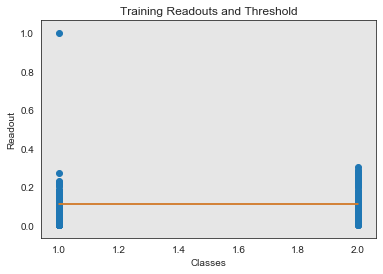

In [35]:
plt.scatter(Y_train, m[-1])
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])
plt.plot([i for i in range(min(number_negative_class, number_positive_class), max(number_negative_class, number_positive_class) + 1)], [test_threshold for _ in range(abs(number_negative_class - number_positive_class) + 1)])
plt.xlabel("Classes")
plt.ylabel("Readout")
plt.title("Training Readouts and Threshold")
plt.show()

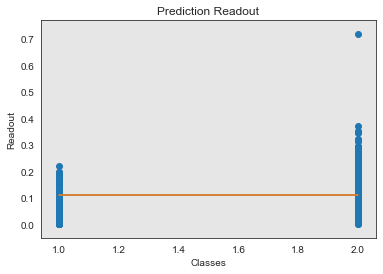

In [36]:
plt.scatter(Y_test, readouts)
plt.plot([i for i in range(number_negative_class, number_positive_class + 1)], [test_threshold for _ in range(number_negative_class, number_positive_class + 1)])
plt.plot([i for i in range(min(number_negative_class, number_positive_class), max(number_negative_class, number_positive_class) + 1)], [test_threshold for _ in range(abs(number_negative_class - number_positive_class) + 1)])
plt.xlabel("Classes")
plt.ylabel("Readout")
plt.title("Prediction Readout")
plt.show()

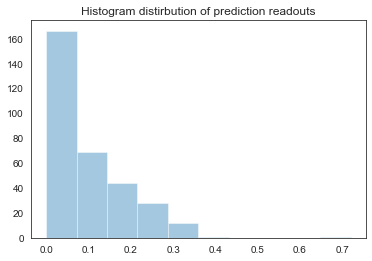

In [37]:
sns.set_style('white')
sns.distplot(readouts, bins = 10, kde=False)
plt.title("Histogram distirbution of prediction readouts")
plt.show()

In [38]:
# Saving to file
#filename = 'weights_semeion_OvO.txt'
#mode = 'a+'
#save_weight(filename = filename, mode = mode, weight = w)

# Multi label prediction

### Loading all the $n\times n$ binary classifiers for naive multiclass classification. Not fully curated

In [39]:
FILE_PATH = os.path.sep.join([os.getcwd(), "Semeion", "OvO"])
weights_matrix = retrieve_weights_from_file(filename = os.path.sep.join([FILE_PATH, "weights_semeion_OvO.txt"]), full = True)

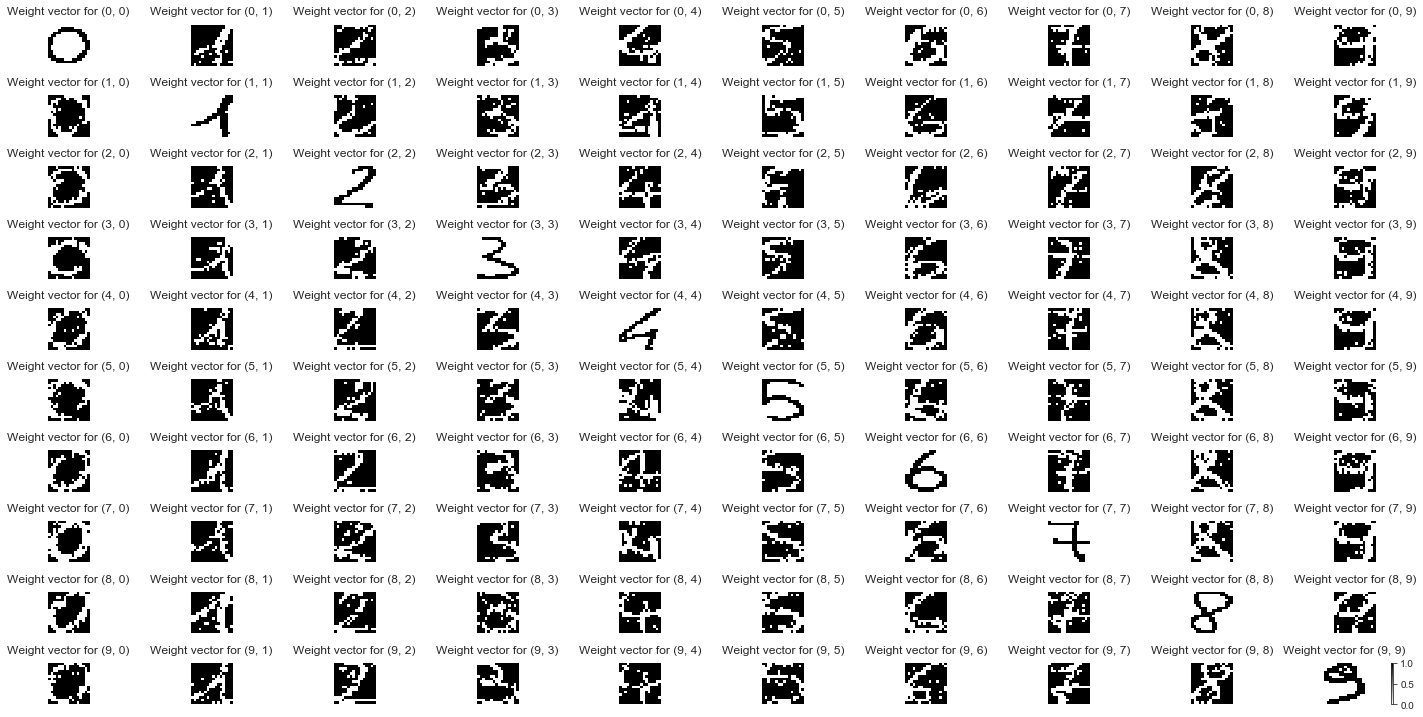

In [42]:
print_weights_matrix(weights_matrix)

In [43]:
data = np.loadtxt(os.path.sep.join([DATASET_PATH, "semeion.data"]))

# Getting images and labels from semeion
images = data[:,:-10]
labels_oh = data[:,-10:]
targets = np.argmax(labels_oh, axis = 1)

print(f'Total count for digits: {Counter(targets)}')
# Splitting dataset
#X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(images, targets, test_size = 0.2, random_state = 10, shuffle = True)
X_test, Y_test = images, targets

Total count for digits: Counter({1: 162, 0: 161, 4: 161, 6: 161, 2: 159, 3: 159, 5: 159, 7: 158, 9: 158, 8: 155})


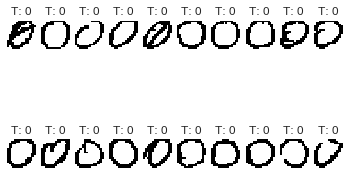

In [44]:
images_and_labels = list(zip(X_test, Y_test))
for index, (image, label) in enumerate(images_and_labels[:20]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('T: %i' % label)

In [46]:
N = 20
test_threshold = 0.109375
Q = 8
classification_patterns = X_test[:N]
classification_labels = Y_test[:N]
shots = 1024 * 8
bias = 0.0

classified_as, holder_for_most_common, holder_for_test, holder_for_readouts = multi_class_prediction(qubits = Q, classification_patterns = classification_patterns, shots = shots, test_threshold = test_threshold, weights_matrix = weights_matrix, bias = bias)

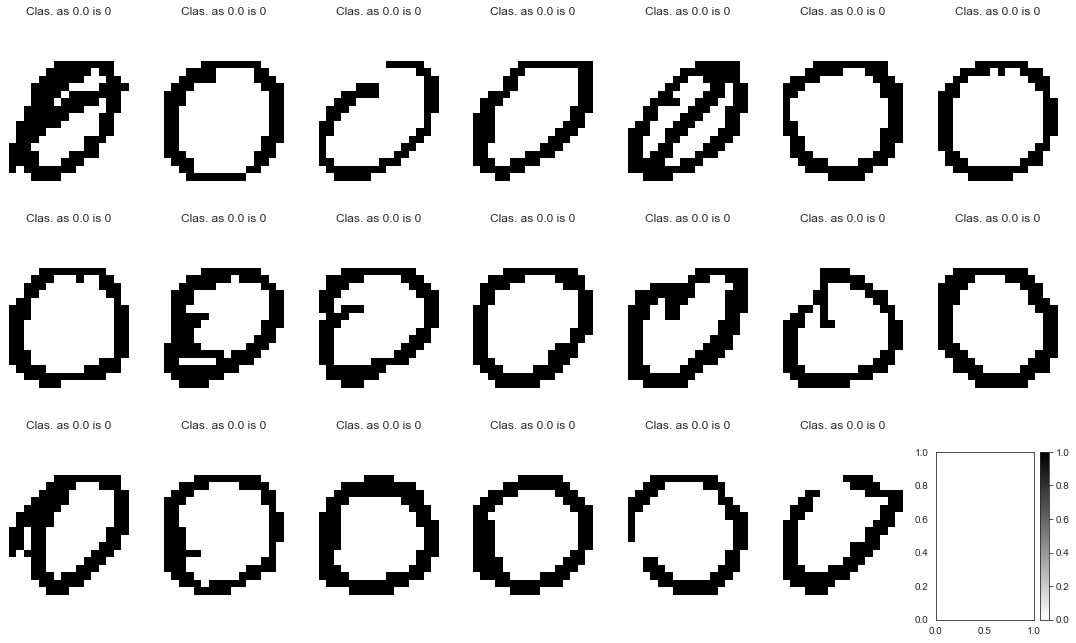

In [47]:
##########################
# Do not run, since it is not optimized it will show a horrible plot
# and it will take too much time to process.
##########################

# Plotting misclassifications

fig, axs = plt.subplots(3, int(np.ceil(len(classification_patterns) / 3)), figsize=(15,9))
count = 0

for i in range(3):
    for j in range(int(np.ceil(len(classification_patterns) / 3))):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(classification_patterns[count]).reshape(16, 16), cmap = 'gray_r', interpolation='nearest')
            ax.axis('off')
            ax.axis('equal')
            ax.set_title(f'Clas. as {classified_as[count]} is {classification_labels[count]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue
        
fig.tight_layout()
plt.colorbar(c)
plt.show()

## Measure performance
#### Some ways to measure the model performance

In [48]:
accuracy = len(np.where(classification_labels == classified_as)[0]) / len(classification_labels)
print(f'Accuracy = {accuracy}')

Accuracy = 1.0


In [49]:
holder_for_test

array([[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
        [0.0, 1.0, 2.0, ..., 2.0, 2.0, 2.0],
        ...,
        [0.0, 1.0, 2.0, ..., 7.0, 7.0, 7.0],
        [0.0, 1.0, 2.0, ..., 7.0, 8.0, 8.0],
        [0.0, 1.0, 2.0, ..., 7.0, 8.0, 9.0]],

       [[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
        [0.0, 1.0, 2.0, ..., 2.0, 2.0, 2.0],
        ...,
        [0.0, 1.0, 2.0, ..., 7.0, 7.0, 7.0],
        [0.0, 1.0, 2.0, ..., 7.0, 8.0, 8.0],
        [0.0, 1.0, 2.0, ..., 7.0, 8.0, 9.0]],

       [[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 1.0, 1.0, ..., 1.0, 8.0, 1.0],
        [0.0, 1.0, 2.0, ..., 2.0, 2.0, 2.0],
        ...,
        [0.0, 1.0, 2.0, ..., 7.0, 7.0, 7.0],
        [0.0, 8.0, 2.0, ..., 7.0, 8.0, 8.0],
        [0.0, 1.0, 2.0, ..., 7.0, 8.0, 9.0]],

       ...,

       [[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 1.0, 1.0, ..., 1.0, 1.0, 9.0],
        [0.0, 1.0, 2.0, ..., 2.0, 2.0, 2.0

In [50]:
# To print only two decimal places
np.set_printoptions(precision=2)

In [51]:
holder_for_readouts.astype(float)

array([[[2.32e-03, 0.00e+00, 3.42e-03, ..., 1.22e-04, 1.02e-01,
         4.64e-03],
        [0.00e+00, 1.34e-03, 3.58e-02, ..., 2.69e-03, 6.67e-02,
         9.77e-03],
        [3.42e-03, 3.58e-02, 4.03e-03, ..., 0.00e+00, 1.02e-01,
         3.66e-03],
        ...,
        [1.22e-04, 2.69e-03, 0.00e+00, ..., 2.44e-04, 2.56e-02,
         6.10e-04],
        [1.02e-01, 6.67e-02, 1.02e-01, ..., 2.56e-02, 1.44e-02,
         3.66e-04],
        [4.64e-03, 9.77e-03, 3.66e-03, ..., 6.10e-04, 3.66e-04,
         3.12e-02]],

       [[2.22e-01, 0.00e+00, 8.54e-03, ..., 4.64e-03, 6.10e-03,
         8.28e-02],
        [0.00e+00, 8.54e-04, 6.25e-02, ..., 1.79e-02, 3.34e-02,
         9.79e-02],
        [8.54e-03, 6.25e-02, 8.30e-03, ..., 1.99e-02, 8.30e-03,
         1.92e-02],
        ...,
        [4.64e-03, 1.79e-02, 1.99e-02, ..., 3.17e-03, 3.66e-04,
         6.42e-02],
        [6.10e-03, 3.34e-02, 8.30e-03, ..., 3.66e-04, 5.40e-02,
         8.94e-02],
        [8.28e-02, 9.79e-02, 1.92e-02, ..., 6.42

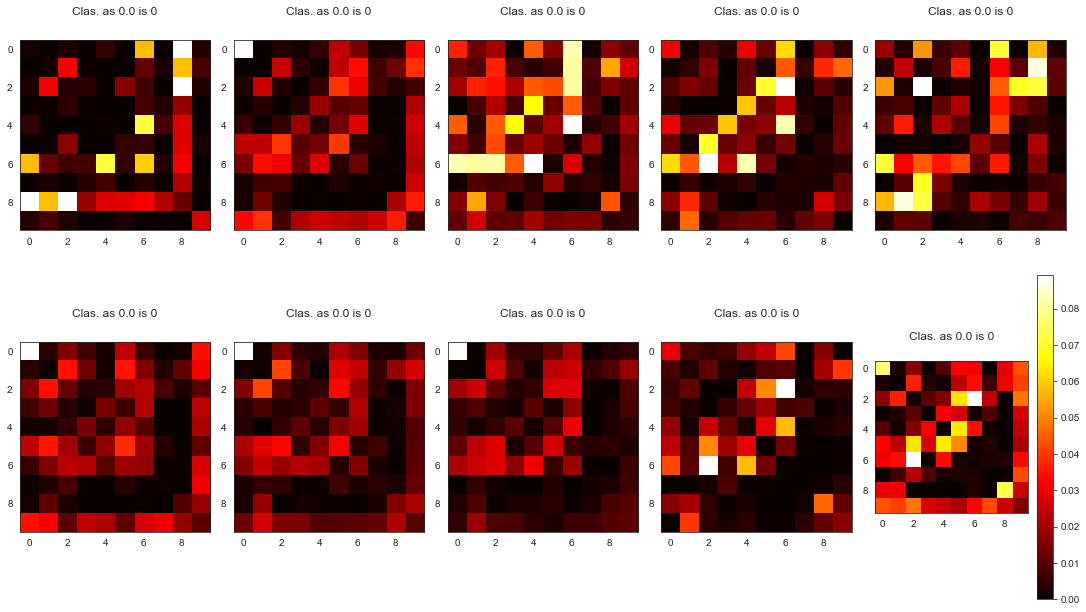

In [52]:
fig, axs = plt.subplots(2,5, figsize=(15,9))
count = 0

for i in range(2):
    for j in range(5):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(np.nan_to_num(holder_for_readouts.astype(float))[count].reshape(10,10)), cmap = 'hot', interpolation='nearest')
            ax.axis('on')
            #ax.axis('equal')
            ax.set_title(f'Clas. as {classified_as[count]} is {classification_labels[count]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue
        
fig.tight_layout()
norm = mpl.colors.Normalize(vmin=np.nan_to_num(holder_for_readouts.astype(float)).min(), vmax=np.nan_to_num(holder_for_readouts.astype(float)).max())
plt.colorbar(c, norm = norm)
plt.show()

In [53]:
np.nan_to_num(holder_for_readouts.astype(float))[9].flatten().argsort()[98:]

array([26, 62], dtype=int64)

In [54]:
np.argmax(np.nan_to_num(holder_for_readouts.astype(float)), axis = 1)

array([[8, 8, 8, 8, 6, 8, 4, 8, 0, 9],
       [0, 9, 5, 9, 6, 5, 1, 9, 9, 1],
       [6, 6, 6, 4, 6, 2, 4, 5, 1, 1],
       [6, 9, 6, 4, 6, 2, 2, 9, 1, 1],
       [6, 8, 2, 6, 6, 8, 0, 2, 1, 1],
       [0, 5, 1, 9, 9, 5, 9, 9, 9, 0],
       [0, 2, 1, 6, 6, 2, 1, 9, 9, 1],
       [0, 2, 6, 6, 6, 2, 4, 9, 9, 1],
       [6, 9, 6, 5, 6, 2, 2, 3, 8, 1],
       [0, 9, 6, 4, 5, 4, 2, 9, 8, 2],
       [0, 9, 6, 4, 6, 2, 4, 9, 8, 1],
       [6, 9, 6, 0, 6, 2, 4, 1, 1, 1],
       [0, 2, 1, 6, 6, 2, 0, 5, 1, 9],
       [0, 5, 1, 9, 9, 5, 9, 9, 2, 7],
       [6, 9, 6, 4, 6, 6, 4, 9, 1, 1],
       [0, 2, 1, 6, 6, 5, 4, 9, 8, 1],
       [0, 6, 5, 6, 6, 2, 4, 2, 9, 9],
       [0, 9, 6, 6, 6, 2, 2, 9, 9, 1],
       [0, 5, 1, 9, 9, 1, 9, 9, 9, 3],
       [0, 8, 6, 5, 6, 2, 2, 1, 8, 8]], dtype=int64)

In [55]:
np.array(list(map(np.argmax, np.nan_to_num(holder_for_readouts.astype(float)))))

array([ 8,  0, 46, 26, 22,  0,  0,  0, 26, 26,  0, 46,  0,  0, 46,  0,  0,
        0,  0,  0], dtype=int64)

In [56]:
trick = np.array(list(map(np.argmax, np.nan_to_num(holder_for_readouts.astype(float))))) % 10
trick

array([8, 0, 6, 6, 2, 0, 0, 0, 6, 6, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0],
      dtype=int64)

In [57]:
classification_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [58]:
accuracy = len(np.where(classification_labels == trick)[0]) / len(classification_labels)
print(f'Accuracy = {accuracy}')

Accuracy = 0.6


In [59]:
np.nan_to_num(holder_for_readouts.astype(float))[9].flatten().argsort()[98:]
np.array(list(map(np.argsort, np.nan_to_num(holder_for_readouts.astype(float).reshape(N, -1)))))[:, :]
another_trick = np.array(list(map(np.argsort, np.nan_to_num(holder_for_readouts.astype(float).reshape(N, -1)))))[:,:]
print(another_trick)

another_trick = another_trick[:, 0]
another_trick = np.array(list(map(lambda x : x//10 if x > 9 else x, another_trick)))
print(another_trick)

[[53 51 15 ... 82  8 80]
 [23  1 32 ... 25 55  0]
 [68 86 58 ...  6 46 64]
 ...
 [67  3 78 ... 62 26  0]
 [38 83 84 ... 51 15  0]
 [95 65 59 ... 26 62  0]]
[5 2 6 5 5 8 4 1 7 7 1 1 9 1 7 7 5 6 3 9]


In [60]:
accuracy = len(np.where(classification_labels == another_trick)[0]) / len(classification_labels)
print(f'Accuracy = {accuracy}')

Accuracy = 0.0


In [61]:
holder_for_most_common

array([[(0.0, 10), (1.0, 9), (2.0, 8), (3.0, 7), (4.0, 6), (5.0, 5),
        (6.0, 4), (7.0, 3), (8.0, 2), (0.0, 1)],
       [(0.0, 10), (1.0, 9), (2.0, 8), (3.0, 7), (4.0, 6), (5.0, 5),
        (6.0, 4), (7.0, 3), (8.0, 2), (0.0, 1)],
       [(0.0, 9), (6.0, 8), (1.0, 7), (2.0, 7), (3.0, 6), (4.0, 6),
        (5.0, 5), (7.0, 3), (8.0, 3), (0.0, 1)],
       [(0.0, 9), (1.0, 9), (3.0, 7), (6.0, 7), (2.0, 6), (5.0, 6),
        (4.0, 5), (7.0, 3), (8.0, 2), (0.0, 1)],
       [(0.0, 10), (1.0, 9), (2.0, 8), (3.0, 7), (4.0, 6), (5.0, 5),
        (6.0, 4), (7.0, 3), (8.0, 2), (0.0, 1)],
       [(0.0, 10), (1.0, 9), (2.0, 8), (3.0, 7), (4.0, 6), (5.0, 5),
        (6.0, 4), (7.0, 3), (8.0, 2), (0.0, 1)],
       [(0.0, 10), (1.0, 8), (2.0, 8), (3.0, 7), (4.0, 6), (5.0, 6),
        (6.0, 4), (7.0, 3), (8.0, 2), (0.0, 1)],
       [(0.0, 10), (1.0, 9), (2.0, 8), (3.0, 7), (4.0, 6), (5.0, 5),
        (6.0, 4), (7.0, 3), (8.0, 2), (0.0, 1)],
       [(0.0, 10), (1.0, 9), (2.0, 7), (3.0, 7), (4.0, 6),

In [62]:
classification_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [63]:
np.array(classified_as).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])